In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, r2_score

from concepts import concept_instances
from train_model import load_model
from utils import load_data, prepare_folders

In [3]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [4]:
# hyperparams for more accurate results, but longer computation time
max_data_size = 5000
k_fold = 5
hyper_param_size = 5
max_training_iter = 100

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = "../runs/20230927-233906/models/model_9999999.pt"
q_network = load_model(model).to(device)
layer = 5

In [6]:
ball_low = concept_instances['ball low (b)']
ball_left = concept_instances['ball left paddle (b)']
reward = concept_instances['reward (b)']
print(ball_low.name, ball_left.name)
data = load_data()
ball_low.prepare_data(data, max_size=max_data_size)
ball_left.prepare_data(data, max_size=max_data_size)
reward.prepare_data(data, max_size=max_data_size)

ball low (b) ball left paddle (b)


In [7]:
def calculate_accuracy(train_acts, train_values, test_acts, test_values):
    reg = linear_model.LogisticRegressionCV(max_iter=max_training_iter, cv=k_fold, Cs=hyper_param_size)
    reg.fit(train_acts, train_values)
    pred = reg.predict(test_acts)
    score = accuracy_score(test_values, pred)
    return reg, 2*score-1

In [8]:
def train_probe(concept):
    _, train_acts_dict = q_network(torch.tensor(concept.obs_train).to(device), return_acts=True)
    _, test_acts_dict = q_network(torch.tensor(concept.obs_test).to(device), return_acts=True)
    train_values = concept.values_train
    test_values = concept.values_test
    train_acts = train_acts_dict[str(layer)].cpu().detach().numpy()
    test_acts = test_acts_dict[str(layer)].cpu().detach().numpy()
    train_acts = train_acts.reshape(len(train_acts), -1)
    test_acts = test_acts.reshape(len(test_acts), -1)
    reg, score = calculate_accuracy(train_acts, train_values, test_acts, test_values)
    print("score:", score)
    return reg

In [9]:
reg1 = train_probe(ball_low)
reg2 = train_probe(ball_left)
reg3 = train_probe(reward)

score: 0.964
score: 0.8280922431865827
score: 0.8888888888888888


In [10]:
# sort images by activations and cav
def sort(images, acts, coefficients):
    norm = np.linalg.norm(coefficients)
    cav = - coefficients
    # sort images by cosine similarity of activations and cav
    images_acts = list(zip(images, acts))
    images_acts.sort(key=lambda x: scipy.spatial.distance.cosine(x[1], cav), reverse=True)
    images, acts = zip(*images_acts)
    return images

In [11]:
def plot_images(images, n):
    # Determine the number of rows required for every 5 images per row
    rows = -(-n // 5)
    fig = plt.figure(figsize=(15, 3 * rows))
    for i in range(n):
        ax = fig.add_subplot(rows, 5, i+1)
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

In [12]:
def sort_images(concept, coefficients):
    images = concept.images_test
    _, test_acts_dict = q_network(torch.tensor(concept.obs_test).to(device), return_acts=True)
    test_acts = test_acts_dict[str(layer)].cpu().detach().numpy()
    test_acts = test_acts.reshape(len(test_acts), -1)

    images = sort(images, test_acts, coefficients)
    plot_images(images, 10)

### Ball low

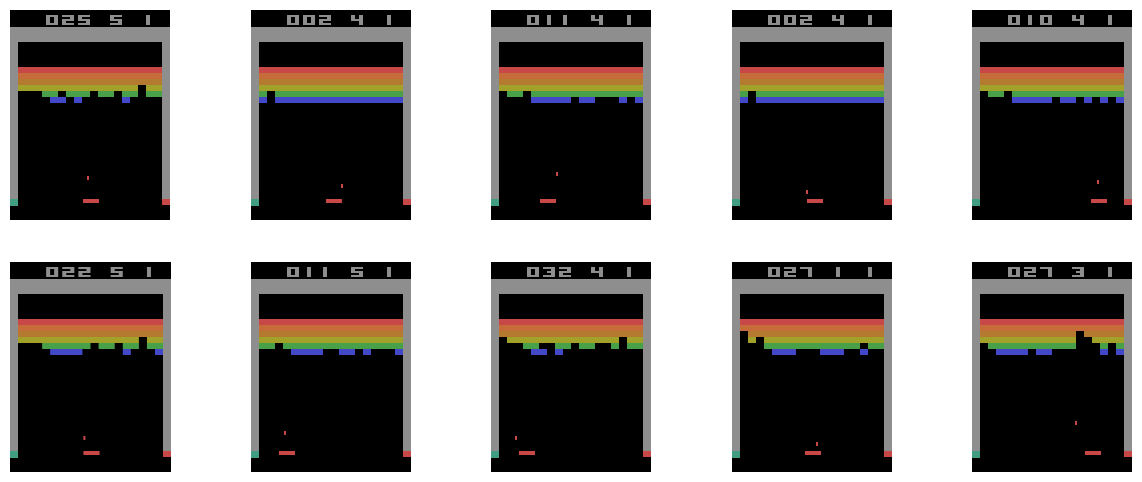

In [13]:
sort_images(ball_low, reg1.coef_[0])

### Ball Left for paddle

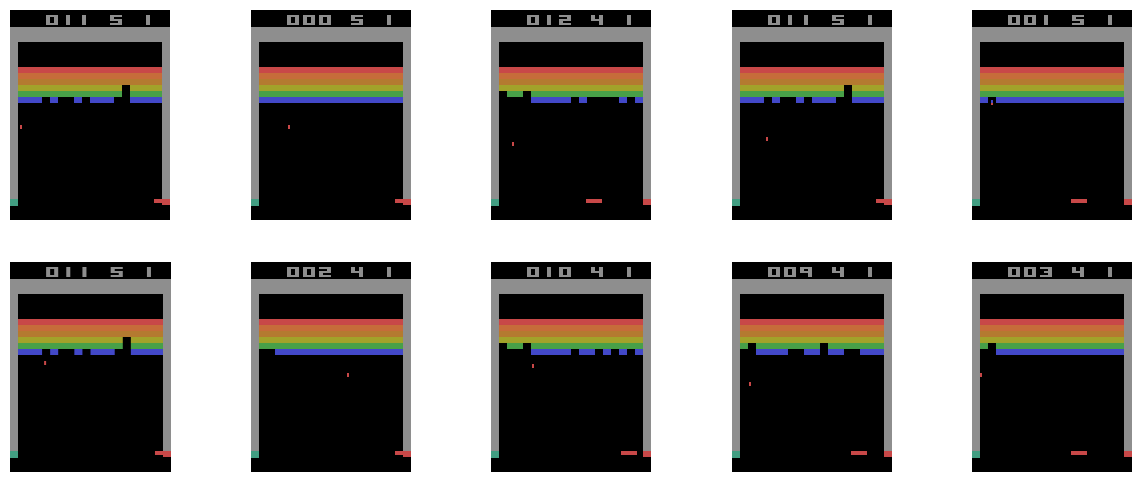

In [14]:
sort_images(ball_left, reg2.coef_[0])

### Reward

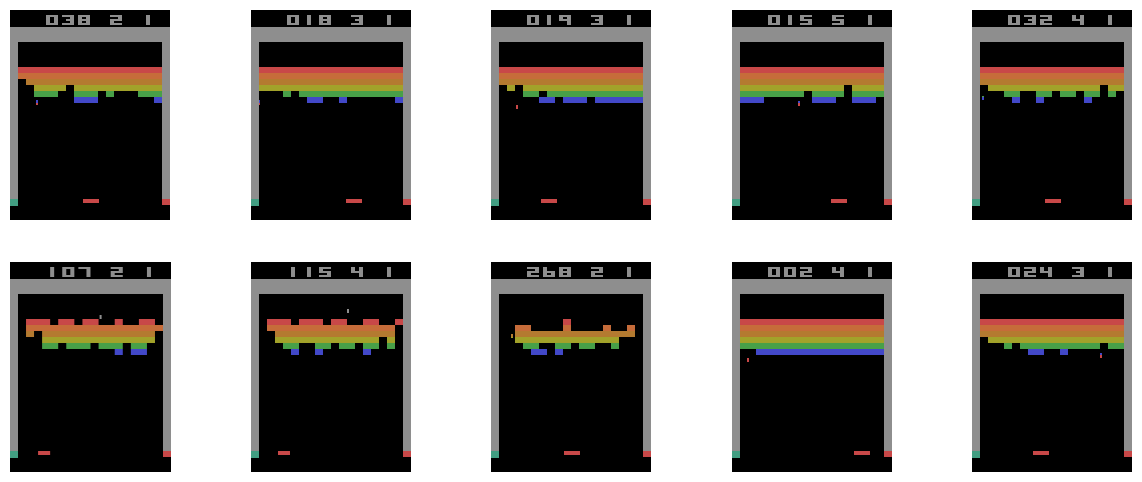

In [15]:
sort_images(reward, reg3.coef_[0])

### Ball left - Ball low

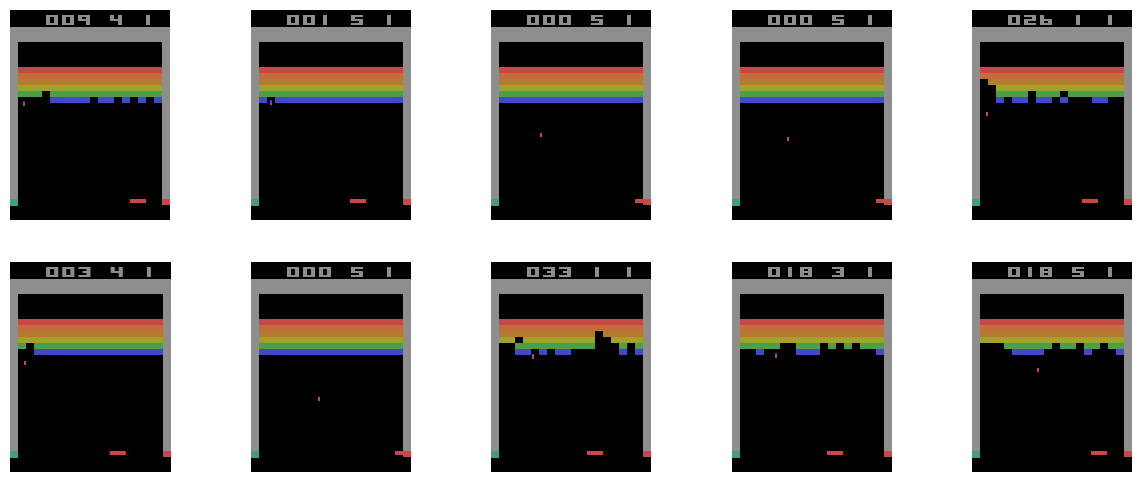

In [16]:
sort_images(ball_low, reg2.coef_[0] - reg1.coef_[0])

### Ball left - Ball low + Reward

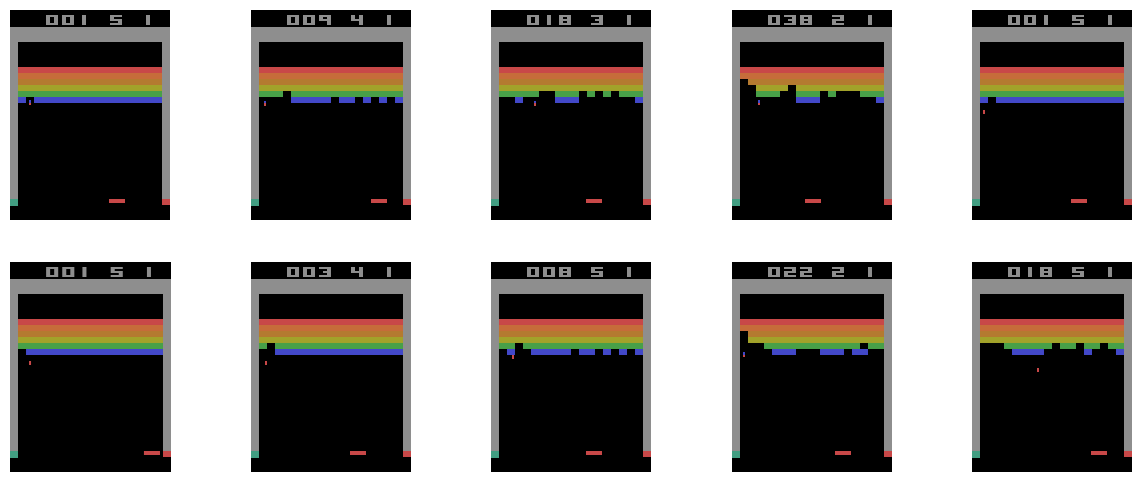

In [17]:
sort_images(ball_low, reg2.coef_[0] - reg1.coef_[0] + reg3.coef_[0])

### Ball left - Ball low - Reward

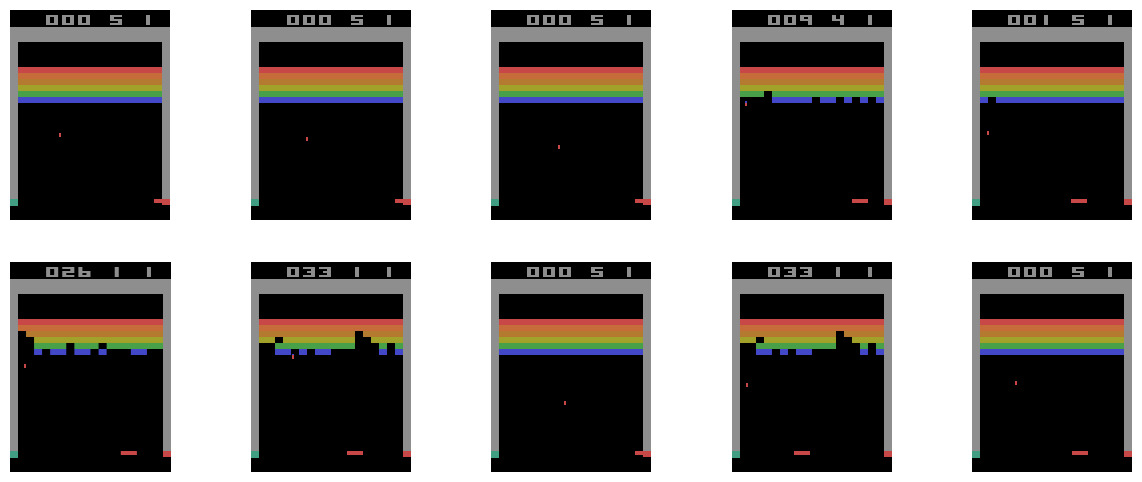

In [18]:
sort_images(ball_low, reg2.coef_[0] - reg1.coef_[0] - reg3.coef_[0])